In [1]:
knitr::opts_chunk$set(echo = TRUE)


## Introduction to Pharmacogenomics and Personalized Cancer Treatment

Large-scale pharmacogenomic studies like the CCLE and GDSC we are investigating have investigated the effects of many anti-cancer drugs on various cell lines. However, the primary interest and motiviation behind these studies is not simply to determine which cell lines are most susceptible to these drugs, but rather **what are the characteristics of the cell lines that are susceptible** to certain drugs? The hope is that this information will be useful in creating improved cancer treatment regimens that will match these characteristics on patients' tumor cells.

If the hope is to create improved treatment regimens in cancer patients, why would we study cell lines? We have to start in cell lines (looking at the *in vitro* response) when screening many drugs at multiple concentrations, since we need to be able to **compare the effects of drugs and doses on cells of the same type**. Cell lines can be grown continously (even in different labs) to generate comparable samples, whereas clinical patient samples are fixed amounts of cells that would be used up after the experiment.

So what are the *characteristics* to examine when attempting to relate the best treatment regimen with a cell line or patient? These consist of genomic factors (e.g. gene expression, copy number, mutation) as well as pharmacologic (e.g. AUC or IC50 of response to various drugs). It is also of interest to investigate whether similar drugs (*similar* could mean similar mechanism of action) have similar effects.

![](Figures/pharmacogenomics_process.jpg)

Figure from "Tumor-Derived Cell Lines as Molecular Models of Cancer Pharmacogenomics" by
Andrew Goodspeed, et al. Mol Cancer Res, 2016.

The CCLE and GDSC studies both investigated genomic profiles for all the cell lines that were used to study drug response. The genomic profiles collected included gene expression measurements for more than 10,000 genes in every cell line (measured by microarray) and mutation status for a subset of 64 genes in every cell line (measured by targeted sequencing). We will not have time to explore this data, but it is available through the R package `PharmacoGx` if you wish to explore it for a future project.

The main finding of Haibe-Kains et al. (2013) (the reanalysis paper) was that the genomic profiles of the cell lines used in both studies were highly correlated. What you might have found so far in your explorations of comparing the summary measures of drug response is that the agreement between the studies does not seem as highly correlated. Part of this may be explained by differences in protocol (which you can see in the different drug concentrations tested in the two studies). In the rest of this tutorial, we'll investigate further sources of variation and biological mechanisms that might explain some of this lack of agreement.

## Load the summarized pharmacological dataset into the session
First, we'll read in the .csv file that contains the summarized pharmacological data (including the IC50 and AUC values for each drug and cell line combination, as described above).



In [2]:
cellLinesSummary <- read.csv("summarizedPharmacoData.csv", header=TRUE)
str(cellLinesSummary)

'data.frame':	2557 obs. of  6 variables:
 $ cellLine : Factor w/ 288 levels "22RV1","5637",..: 1 2 3 4 5 6 8 9 10 11 ...
 $ drug     : Factor w/ 15 levels "17-AAG","AZD0530",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ ic50_CCLE: num  8 7.48 8 1.91 8 ...
 $ auc_CCLE : num  0 0.00726 0.07101 0.15734 0 ...
 $ ic50_GDSC: num  155.27 219.93 92.18 3.06 19.63 ...
 $ auc_GDSC : num  0.00394 0.00362 0.00762 0.06926 0.02876 ...



## Resistance of Cell lines and the effect on replicability

Something that was not considered in the original comparison analyses by Haibe-Kains et al. reanalysis paper was that different cell lines may more or less **resistant** (resistance means that the cell line does not respond to treatment by a drug) to drug treatment than others. Let's explore first why that might be an important factor, and then directly compare cell line sensitivity in the two studies.

Consider the following situation: say we have a set of cell lines that are resistant to a particular drug (they don't respond to it). Then we would expect that no matter what dose we give to the cell lines, their viability results would not change (they would stay near 100%). In this case, the AUC (area above the response curve) value would be near zero since the dose-response curve would look flat:

![](Figures/resistant.jpg)

How would you calculate the IC50 value in this case?

> Place your answer here

Assuming the results in both studies were consistent, then a scatterplot of the AUC values in this case would look like this (allowing for experimental error - we don't expect to get exactly 100% viability at each dose due to variations in the experimental conditions and cellular growth rates):



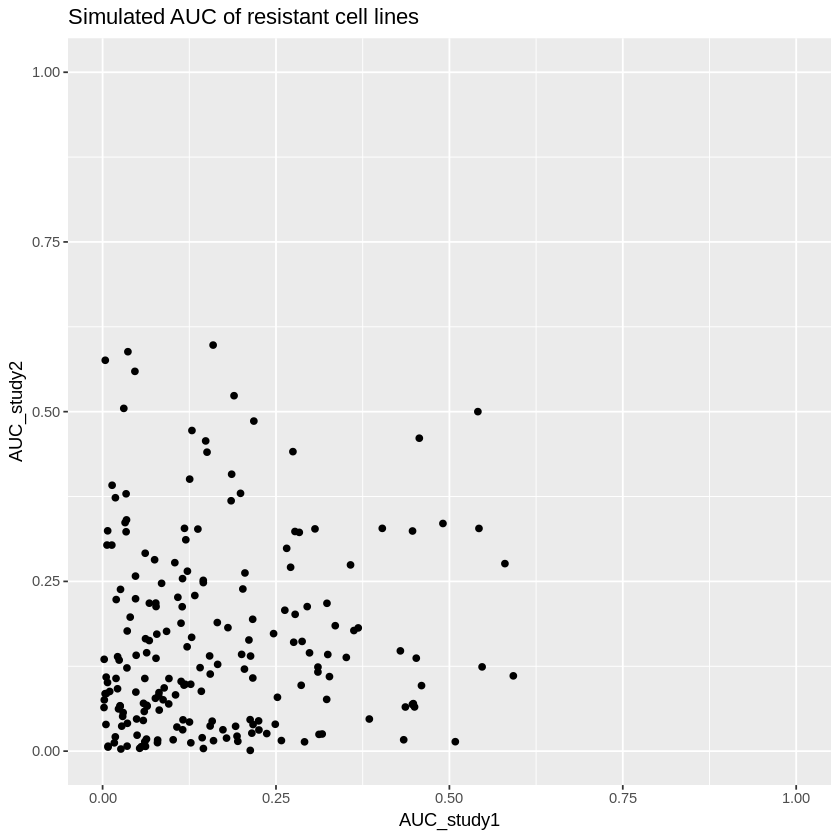

In [3]:
library(ggplot2)
AUC_study1 <- rbeta(200, 1, 5)
AUC_study2 <- rbeta(200, 1, 5)
resistant <- data.frame(AUC_study1, AUC_study2)
ggplot(resistant, aes( y=AUC_study2, x=AUC_study1) ) +
    geom_point() + ggtitle("Simulated AUC of resistant cell lines") +
    xlim(0,1) + ylim(0,1)


Here we have simulated the AUC values in each study to be closer to zero but with some random variability (this is done here using the Beta distribution). Do these AUC values look correlated? Calculate a correlation coefficient to quantify the correlation.

> Place your answer here

Now, consider the situation where only half of the cell lines are resistant (with AUC values close to zero) and half are sensitive (with high AUC values).



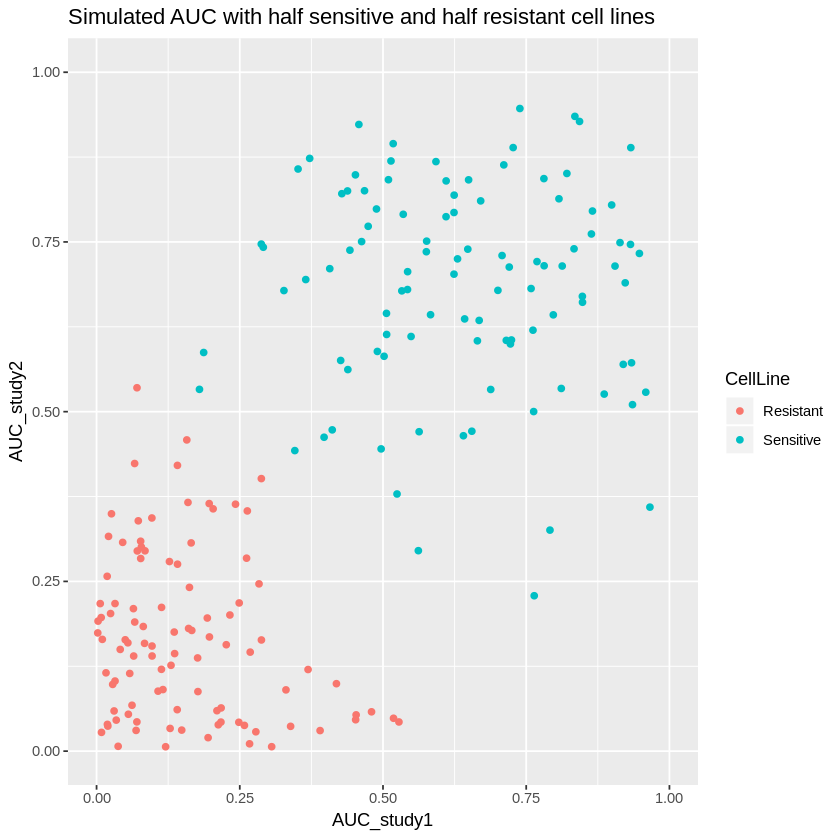

In [4]:
AUC_study1 <- c(rbeta(100, 1, 5), rbeta(100, 4, 2))
AUC_study2 <- c(rbeta(100, 1, 5), rbeta(100, 4, 2))
resistant <- data.frame(AUC_study1, AUC_study2,
                        CellLine=c(rep("Resistant", 100), rep("Sensitive", 100)))
ggplot(resistant, aes( y=AUC_study2, x=AUC_study1, colour=CellLine) ) +
    geom_point() + ggtitle("Simulated AUC with half sensitive and half resistant cell lines") +
    xlim(0,1) + ylim(0,1)


Here we have simulated half the AUC values in each study to be closer to zero and half to be closer to one but with some random variability (using the Beta distribution again). Do these AUC values look correlated? Calculate a correlation coefficient to quantify the correlation.

> Place your answer here

If all cell lines are resistant to a particular drug, would you expect to find a high correlation between the two studies for that drug? Would that result imply that the two studies are not replicable?

> Place your answer here

Now, let's explore the average drug responses by cell line. First, we'll compute the average drug responses by cell line (averaged over all drugs). Then we'll create a scatterplot to compare these averages in the two studies.




Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



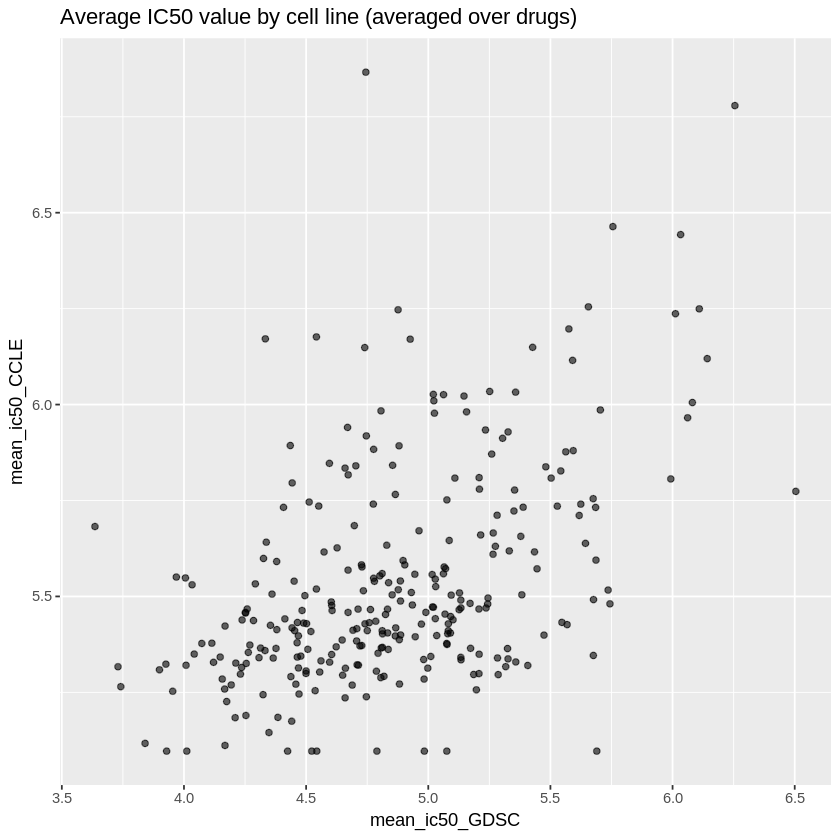

In [5]:
library(tidyr)
library(plyr)
library(dplyr)

drugAvg <- cellLinesSummary %>%
              group_by(cellLine) %>%
              summarise(mean_ic50_CCLE = mean(-log10(ic50_CCLE/10^6)),
                        mean_ic50_GDSC = mean(-log10(ic50_GDSC/10^6)),
                        mean_auc_CCLE = mean(auc_CCLE),
                        mean_auc_GDSC = mean(auc_GDSC))

ggplot(drugAvg, aes(x=mean_ic50_GDSC, y=mean_ic50_CCLE)) +
    geom_point(alpha=0.6) +
    ggtitle("Average IC50 value by cell line (averaged over drugs)")

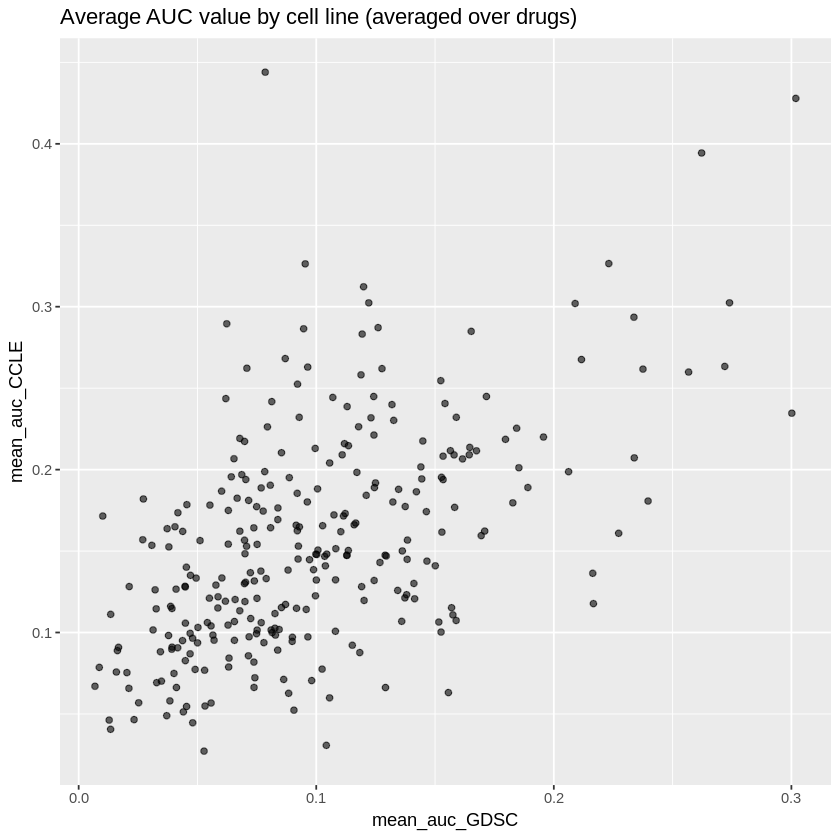

In [6]:
ggplot(drugAvg, aes(x=mean_auc_GDSC, y=mean_auc_CCLE)) +
    geom_point(alpha=0.6) +
    ggtitle("Average AUC value by cell line (averaged over drugs)")


What is the most sensitive cell line?

> Place your answer here

## Replicability results for sensitive versus resistant cell lines

So far we've seen that the sensitivity of cell lines can have major implications for the perceived replicability of studies if we use standard correlation measures for assessment. For this reason, some of the followup articles indicated that sensitivity should be taken into account in this kind of analysis. How can we consider sensitivity when assessing replicability of the two studies? One idea is to assess the agreement between the studies on which cell lines were sensitive or resistant (instead of agreement on the actual values of AUC or IC50).

To assess agreement between the studies on which cell lines were sensitive or resistant, we first have to define criteria for deciding whether a cell line is resistant or not. In other words, we'd like to choose an AUC cutoff that divides sensitive and resistant responses. This choice is somewhat arbitrary, we'll start by choosing the following cutoffs: AUC values 0.1 or higher indicate that the cell line is sensitive to the drug, and AUC values below 0.1 indicate that the cell line is resistant (unless no cell lines had observed AUC values above 0.1 in either study, then use 0.4. This is the case for the broadly cytotoxic drug paclitaxel). You are encouraged to try other cutoffs as well.

Let's go ahead and add sensitivity variables to our dataset, and explore their basic properties.



In [7]:
cellLinesSummary <- cellLinesSummary %>%
              mutate(cutoff = ifelse(drug=="paclitaxel", 0.4, 0.1)) %>%
              mutate(sensitivity_GDSC = factor(ifelse( auc_GDSC < cutoff, "Resistant", "Sensitive")),
                     sensitivity_CCLE = factor(ifelse( auc_CCLE < cutoff, "Resistant", "Sensitive")))

table("GDSC"=cellLinesSummary$sensitivity_GDSC, "CCLE"=cellLinesSummary$sensitivity_CCLE)

           CCLE
GDSC        Resistant Sensitive
  Resistant      1289       486
  Sensitive       217       565


What proportion of the drug-cell line combinations are in agreement of sensitivity/resistance between the two studies?

> Place your answer here

Next, we'll create a scatterplot of the AUC values, colored by sensitivity. We'll start with just the drug "PLX4720".




                 Both Resistant                  Both Sensitive 
                           1289                             565 
GDSC Resistant / CCLE Sensitive GDSC Sensitive / CCLE Resistant 
                            486                             217 

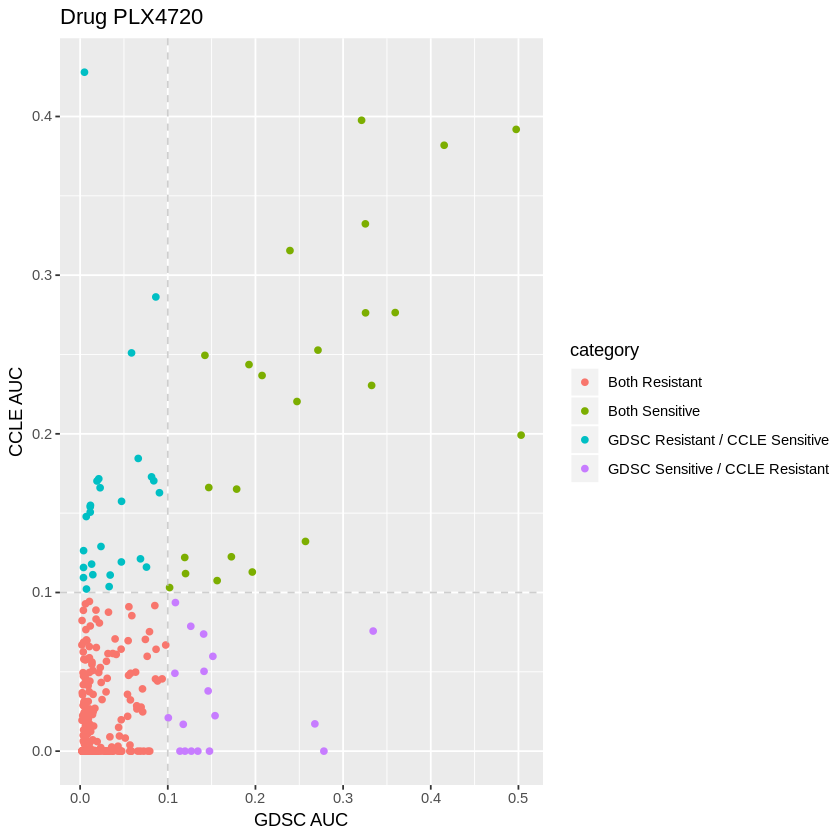

In [8]:
cellLinesSummary <- cellLinesSummary %>%
              mutate(category = paste(sensitivity_GDSC, sensitivity_CCLE)) %>%
              mutate(category = revalue(category, c("Resistant Resistant" = "Both Resistant",
                                                    "Sensitive Sensitive" = "Both Sensitive",
                                                    "Resistant Sensitive" = "GDSC Resistant / CCLE Sensitive",
                                                    "Sensitive Resistant" = "GDSC Sensitive / CCLE Resistant")))
table(cellLinesSummary$category)

ggplot(aes(x=auc_GDSC, y=auc_CCLE, colour=category), data=subset(cellLinesSummary, drug=="PLX4720")) +
    geom_point() +
    xlab("GDSC AUC") +
    ylab("CCLE AUC") +
    geom_hline(aes(yintercept=cutoff), colour="grey", alpha=0.75, lty=2) +
    geom_vline(aes(xintercept=cutoff), colour="grey", alpha=0.75, lty=2) +
    ggtitle("Drug PLX4720")


In this plot, which colors of points correspond to 'agreement' between the two studies?

> Place your answer here

Overall, do most cell lines seem to agree or disagree in whether they were sensitive or resistant to PLX4720?

> Place your answer here

Next, we'll create the same scatterplot above, but for all drugs, so we can compare them side by side.



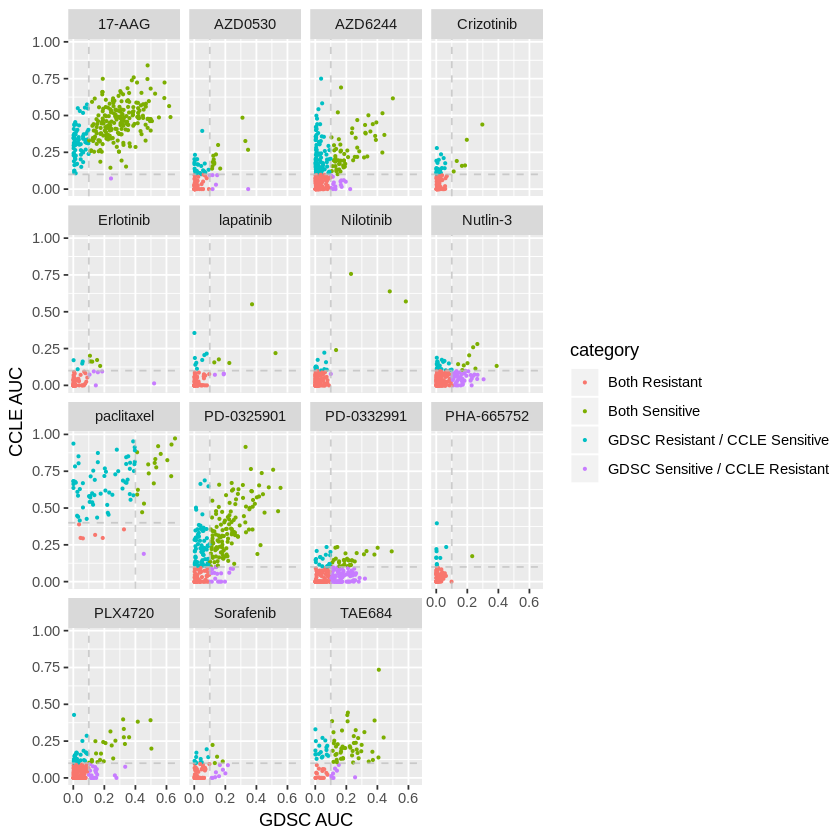

In [9]:
ggplot(aes(x=auc_GDSC, y=auc_CCLE, colour=category), data=cellLinesSummary) +
    geom_point(cex=0.5) +
    facet_wrap(facets=~drug) +
    xlab("GDSC AUC") +
    ylab("CCLE AUC") +
    geom_hline(aes(yintercept=cutoff), colour="grey", alpha=0.75, lty=2) +
    geom_vline(aes(xintercept=cutoff), colour="grey", alpha=0.75, lty=2)


Now that we have explored these results visually, is there a way to summarize the agreement for each drug numerically? Right away we might think of calculating Pearson or Spearman correlation. However, these measures are intended to measure correlation between either continuous variables or variables with several unique values. Here we only have 2 categories: sensitive and resistant. So we'll turn to a correlation measure called Matthews correlation coefficient (MCC), which is designed to calculate the agreement based on binary (2-category) classifications.

Without getting into too much detail about the statistic, let's go ahead and see how it is calculated, and compare its values across all the drugs.



drug,matthews_corr
17-AAG,-0.03496447
AZD0530,0.29344484
AZD6244,0.29738378
Crizotinib,0.37051899
Erlotinib,0.43221037
lapatinib,0.42363536
Nilotinib,0.35583000
Nutlin-3,0.08562279
paclitaxel,0.04319966
PD-0325901,0.37324175


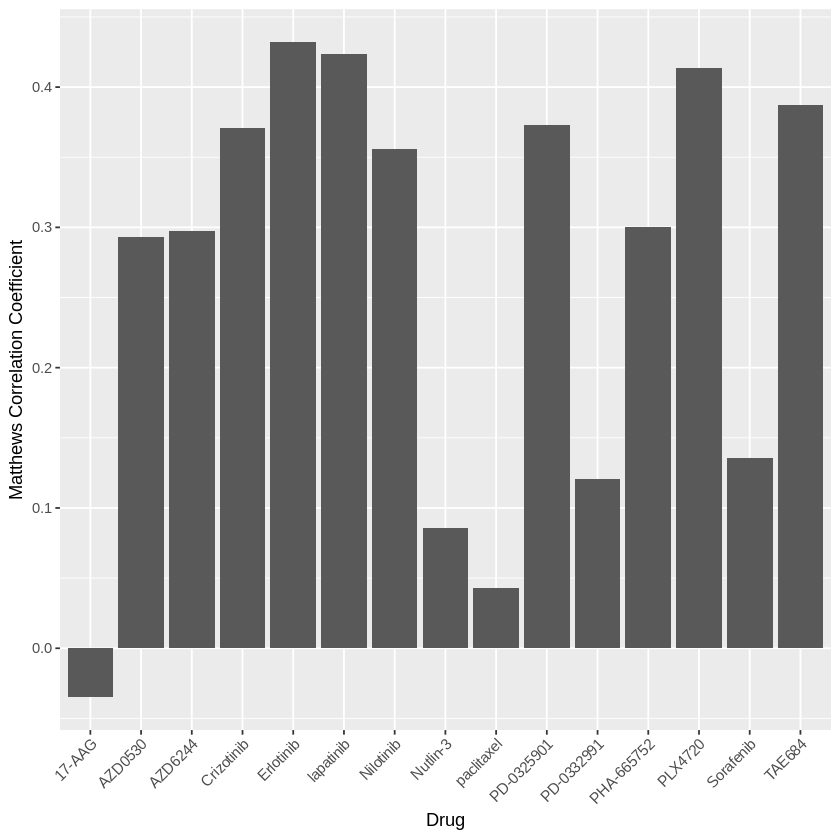

In [10]:
# Function to calculate the MCC from two vectors with possible values "Sensitive" and "Resistant"
mcc <- function (study1, study2)
{
  BS <- sum(study1 == "Sensitive" & study2 == "Sensitive")
  BR <- sum(study1 == "Resistant" & study2 == "Resistant")
  SR <- sum(study1 == "Sensitive" & study2 == "Resistant")
  RS <- sum(study1 == "Resistant" & study2 == "Sensitive")

  if (BS+SR == 0 | BS+RS == 0 | BR+SR == 0 |  BR+RS ==0){
    mcc <- ((BS*BR)-(SR*RS))
  }else{
    mcc <- ((BS*BR)-(SR*RS)) / sqrt(exp((log(BS+SR)+log(BS+RS)+log(BR+SR)+log(BR+RS))))
  }
  return(mcc)
}

drugCorrs <- cellLinesSummary %>%
  group_by(drug) %>%
  summarise(matthews_corr=mcc(sensitivity_GDSC, sensitivity_CCLE))

drugCorrs

ggplot(data=drugCorrs, aes(x=drug, y=matthews_corr)) +
  geom_bar(stat="identity") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  xlab("Drug")+
  ylab("Matthews Correlation Coefficient")



Examining the Matthew's correlation values that take into account cell line categories, which drug do you think shows the most consistency between the studies? How about the least?

> Place your answer here

Does this agree with your visual assessment and answers to these same questions in the previous tutorial (tutorial 2) using continuous correlation measures (Pearson and Spearman)?

> Place your answer here

## Targeted versus Broad Effect Drugs

In addition to sensitivity of cell lines, another biological factor that might have major implications for the perceived replicability of studies is the **targeted** nature of the drugs used. A drug is considered **targeted** if it is expected to have selective activity against some cell lines. The mechanism of impact on perceived replicability is very similar to the impact of sensitivity of cell lines: the response in the cell lines that the drug does *not* target may represent random noise (and we don't expect to observe correlations in random noise). For this reason, some of the followup articles indicated that drugs should be considered separately based on their targeted nature.

[Safikhani et al.](https://f1000research.com/articles/5-2333/v1) describe the following three classes of drugs based on observed responses of the cell lines:

* **No effect**: minimal observed resposne for all cell lines
    + sorafenib
    + erlotinib
    + PHA-665752
* **Narrow effect**: response in only a small subset of cell lines
    + nilotinib
    + lapatinib
    + nutlin-3
    + PLX44720
    + crizotinib
    + PD-0332991
    + AZD0530
    + TAE684
* **Broad effect**: response in a large number of cell lines
    + AZD6244
    + PD-0325901
    + 17-AAG
    + paclitaxel

Consider, for example, the drugs sorafenib and nilotinib. In the context of these drug classes, which would you expect to have a larger MCC and why? Are the observed MCC values consistent with this?

> Place your answer here
